<a href="https://colab.research.google.com/github/manasvimishra11/News-Summarization-using-models-like-BART-T5-and-Pegasus/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Important Packages**

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00


In [ ]:
pip install rouge

In [ ]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00


# **Code**

In [ ]:
import os
import random
from transformers import BartForConditionalGeneration, BartTokenizer,T5ForConditionalGeneration, T5Tokenizer,pipeline,PegasusForConditionalGeneration, PegasusTokenizer
from rouge import Rouge

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
dataset_folder = "/content/gdrive/MyDrive/BBC News Summary"
news_articles_folder = "News Articles"
summaries_folder = "Summaries"
num_articles = 510
num_articles_to_select = 75

In [ ]:
# Function to read articles and summaries from the dataset
def read_articles_and_summaries(dataset_folder, num_articles):
    articles = []
    summaries = []

    for i in range(1, num_articles + 1):
        article_file = os.path.join(dataset_folder, news_articles_folder, f"{i:03d}.txt")
        summary_file = os.path.join(dataset_folder, summaries_folder, f"{i:03d}.txt")

        with open(article_file, "r", encoding="utf-8") as article_file:
            articles.append(article_file.read())

        with open(summary_file, "r", encoding="utf-8") as summary_file:
            summaries.append(summary_file.read())

    return articles, summaries

# **1. BART Model**

In [ ]:
# Load pre-trained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

In [ ]:
# Function to generate summaries and calculate ROUGE scores using BART
def generate_summary_and_rouge(text, reference_summary):
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)
    generated_summary = summarizer(text, max_length=250, min_length=30, do_sample=False)[0]["summary_text"]

    # Calculate ROUGE scores
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summary, reference_summary, avg=True)

    return generated_summary, rouge_scores

# **2. T5 Model**

In [ ]:
#Load pretrained model
t5_model_name = "t5-small"
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name)
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def generate_t5_summary_and_rouge(text, reference_summary):
    inputs = t5_tokenizer("summarize: " + text, return_tensors="pt", max_length=300, truncation=True)
    summary_ids = t5_model.generate(inputs.input_ids, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
    generated_summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Calculate ROUGE scores
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summary, reference_summary, avg=True)

    return generated_summary, rouge_scores


# **3. Pegasus Model**

In [ ]:
# Load Pegasus model and tokenizer
pegasus_model_name = "google/pegasus-cnn_dailymail"
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name)
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Function to generate summaries and calculate ROUGE scores using PEGASUS
def generate_pegasus_summary_and_rouge(text, reference_summary):
    inputs = pegasus_tokenizer([text], max_length=350, return_tensors="pt", truncation=True)
    summary_ids = pegasus_model.generate(inputs.input_ids, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
    generated_summary = pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Calculate ROUGE scores
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summary, reference_summary, avg=True)

    return generated_summary, rouge_scores

# **Comparative Analysis**

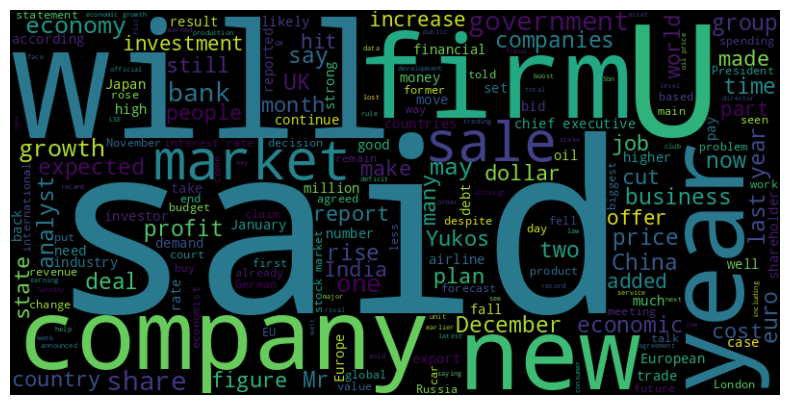

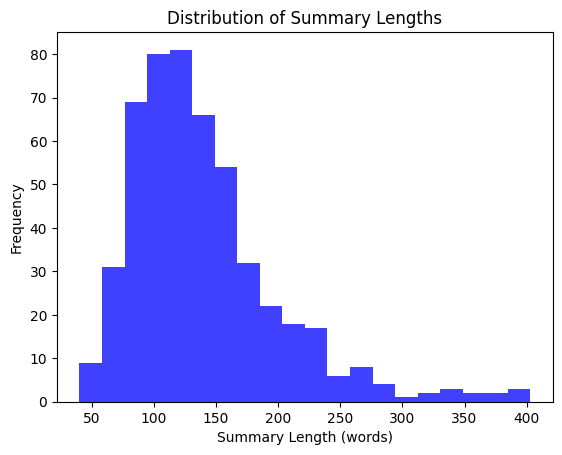

Mean article length: 328.88039215686274
Mean summary length: 139.9294117647059


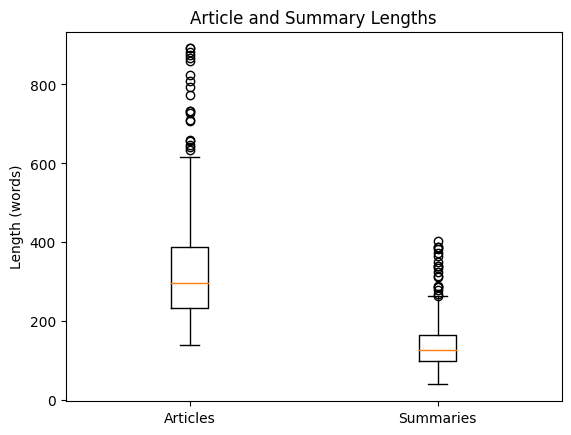

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
# Basic Dataset Overview
num_articles = len(articles)
num_summaries = len(summaries)

# Distribution of Article and Summary Lengths
article_lengths = [len(article.split()) for article in articles]
summary_lengths = [len(summary.split()) for summary in summaries]

# Vocabulary Analysis
def get_word_frequencies(text):
    word_counts = Counter(text.split())
    return word_counts

article_word_frequencies = get_word_frequencies(' '.join(articles))
summary_word_frequencies = get_word_frequencies(' '.join(summaries))

# Word Cloud
wordcloud = WordCloud(width=800, height=400).generate(' '.join(articles))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Summary Length Analysis
plt.hist(summary_lengths, bins=20, alpha=0.75, color='b')
plt.xlabel('Summary Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Summary Lengths')
plt.show()

# Statistical Analysis
print('Mean article length:', sum(article_lengths) / len(article_lengths))
print('Mean summary length:', sum(summary_lengths) / len(summary_lengths))

# Visualization of Article and Summary Lengths
plt.boxplot([article_lengths, summary_lengths], labels=['Articles', 'Summaries'])
plt.ylabel('Length (words)')
plt.title('Article and Summary Lengths')
plt.show()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def calculate_meteor(reference, candidate):
    # Tokenize the reference and candidate sentences
    reference_tokens = word_tokenize(reference)
    candidate_tokens = word_tokenize(candidate)

    # Calculate METEOR score
    return meteor_score([reference_tokens], candidate_tokens)

def calculate_rouge_p(reference, candidate):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference, avg=True)
    return scores['rouge-1']['p']

if __name__ == "__main__":
    # Read articles and summaries from the dataset
    articles, summaries = read_articles_and_summaries(dataset_folder, num_articles)

    # Select random articles
    random_articles = random.sample(range(num_articles), num_articles_to_select)

    bart_rouge_1_scores = []
    t5_rouge_1_scores = []
    pegasus_rouge_1_scores = []

    meteor_bart_scores = []
    meteor_t5_scores = []
    meteor_pegasus_scores = []

    rouge_p_bart_scores = []
    rouge_p_t5_scores = []
    rouge_p_pegasus_scores = []


    # Generate summaries and calculate ROUGE scores for the selected articles using BART and T5
    for article_index in random_articles:
        try:
            article = articles[article_index]
            summary = summaries[article_index]

            # Generate BART summary and calculate ROUGE scores
            bart_summary, bart_rouge_scores = generate_summary_and_rouge(article, summary)
            bart_rouge_1_scores.append(bart_rouge_scores['rouge-1']['r'])

            # Generate T5 summary and calculate ROUGE scores
            t5_summary, t5_rouge_scores = generate_t5_summary_and_rouge(article, summary)
            t5_rouge_1_scores.append(t5_rouge_scores['rouge-1']['r'])

            # Generate PEGASUS summary and calculate ROUGE scores
            pegasus_summary, pegasus_rouge_scores = generate_pegasus_summary_and_rouge(article, summary)
            pegasus_rouge_1_scores.append(pegasus_rouge_scores['rouge-1']['r'])

            # Calculate METEOR scores
            meteor_bart_score = calculate_meteor(summary, bart_summary)
            meteor_bart_scores.append(meteor_bart_score)

            meteor_t5_score = calculate_meteor(summary, t5_summary)
            meteor_t5_scores.append(meteor_t5_score)

            meteor_pegasus_score = calculate_meteor(summary, pegasus_summary)
            meteor_pegasus_scores.append(meteor_pegasus_score)

            rouge_p_bart_score = calculate_rouge_p(summary, bart_summary)
            rouge_p_bart_scores.append(rouge_p_bart_score)

            rouge_p_t5_score = calculate_rouge_p(summary, t5_summary)
            rouge_p_t5_scores.append(rouge_p_t5_score)

            rouge_p_pegasus_score = calculate_rouge_p(summary, pegasus_summary)
            rouge_p_pegasus_scores.append(rouge_p_pegasus_score)

            print(f"\nArticle {article_index + 1} Summaries:")
            print("Original Summary:")
            print(summary)
            print("\nGenerated Summary (BART):")
            print(bart_summary)
            print("ROUGE Scores (BART):")
            print(bart_rouge_scores)
            print("\nGenerated Summary (T5):")
            print(t5_summary)
            print("ROUGE Scores (T5):")
            print(t5_rouge_scores)
            print("\nGenerated Summary (PEGASUS):")
            print(pegasus_summary)
            print("ROUGE Scores (PEGASUS):")
            print(pegasus_rouge_scores)
        except IndexError as e:
            print(f"Encountered an IndexError for article index {article_index}: {str(e)}")
            continue

    # Calculate average ROUGE scores for each model
    average_bart_rouge_1 = sum(bart_rouge_1_scores) / len(bart_rouge_1_scores)
    average_t5_rouge_1 = sum(t5_rouge_1_scores) / len(t5_rouge_1_scores)
    average_pegasus_rouge_1 = sum(pegasus_rouge_1_scores) / len(pegasus_rouge_1_scores)

    print("\nAverage ROUGE Scores:")
    print("BART (rouge-1):", average_bart_rouge_1)
    print("T5 (rouge-1):", average_t5_rouge_1)
    print("PEGASUS (rouge-1):", average_pegasus_rouge_1)

    # Calculate average METEOR scores for each model
    average_meteor_bart = sum(meteor_bart_scores) / len(meteor_bart_scores)
    average_meteor_t5 = sum(meteor_t5_scores) / len(meteor_t5_scores)
    average_meteor_pegasus = sum(meteor_pegasus_scores) / len(meteor_pegasus_scores)

    print("\nAverage METEOR Scores:")
    print("BART:", average_meteor_bart)
    print("T5:", average_meteor_t5)
    print("PEGASUS:", average_meteor_pegasus)

    # Calculate average ROUGE-P scores for each model
    average_rouge_p_bart = sum(rouge_p_bart_scores) / len(rouge_p_bart_scores)
    average_rouge_p_t5 = sum(rouge_p_t5_scores) / len(rouge_p_t5_scores)
    average_rouge_p_pegasus = sum(rouge_p_pegasus_scores) / len(rouge_p_pegasus_scores)

    print("\nAverage ROUGE-P Scores:")
    print("BART (rouge-p):", average_rouge_p_bart)
    print("T5 (rouge-p):", average_rouge_p_t5)
    print("PEGASUS (rouge-p):", average_rouge_p_pegasus)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Article 440 Summaries:
Original Summary:
Although China's overall trade surplus is expanding, according to Chinese government figures, the Commerce Department revealed the US's deficit with China was $19.6bn in November, down from $19.7bn the month before.Against the pound, the dollar was down about 0.7% at $1,8923.But the deficit with Japan was at its worst in more than four years.The gap between US exports and imports has widened to more than $60bn (£31.7bn), an all-time record.One small bright spot for US policy-makers was a slight decline in the deficit with China, often blamed for job losses and other economic woes.By 1650 GMT, the dollar was trading against the euro at $1.3280, almost a cent and a half weaker than before the announcement.But the numbers suggested the sliding dollar - which makes exports less expensive - has had little impact, and could indicate slowing economic growth.The trade deficit is a large part of the latter.

Generated Summary (BART):
US trade deficit wi

Your max_length is set to 250, but your input_length is only 231. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=115)



Article 338 Summaries:
Original Summary:
Chinese police have detained three top executives at milk firm Yili, with reports suggesting that they are being investigated for embezzlement.Analysts wondered if the scandal at Yili - the latest to befall Chinese companies this year - could be followed by further revelations of corporate wrongdoing.A Yili spokesman said it may now move to oust chairman Zheng Junhuai.Yili - full name Inner Mongolia Yili Industrial - confirmed its chairman, chief financial officer and securities representative were all in custody.Yili has recently been the subject of intense media speculation over its financial operations.

Generated Summary (BART):
Police detain three top executives at milk firm Yili. Reports suggest they are being investigated for embezzlement. Yili spokesman says it may now move to oust chairman Zheng Junhuai.
ROUGE Scores (BART):
{'rouge-1': {'r': 0.2839506172839506, 'p': 0.8214285714285714, 'f': 0.4220183448059928}, 'rouge-2': {'r': 0.2021

Your max_length is set to 250, but your input_length is only 246. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=123)



Article 448 Summaries:
Original Summary:
US prosecutors have charged nine food suppliers with helping Dutch retailer Ahold inflate earnings by more than $800m (£428m).The nine now charged, who worked as suppliers to Ahold, are accused of signing false documents relating to the amount of money they paid the retailer for promoting their products in its stores.The suppliers in question are said to have inflated the amount of money they paid, providing auditors with signed letters that allowed Ahold to inflate its earnings.Ahold is the world's fourth-largest supermarket chain.Ahold hit the headlines in February 2003 after it emerged that there were accounting irregularities at its US subsidiary Foodservice.It was less severe than many had envisaged, however, and since then Ahold has worked hard at rebuilding its reputation and investor confidence.At the time of the scandal, Ahold was seen by many as Europe's Enron.Pasquale D'Amuro of the FBI called the nine vendors the key ingredients in 

Your max_length is set to 250, but your input_length is only 221. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=110)



Article 125 Summaries:
Original Summary:
Trade Minister Mark Vaile has said that the bid may be "against the national interest".Australian mining firm WMC Resources has seen a fivefold rise in profits while continuing to be the target of a hostile takeover bid.WMC said it made net profits of 1.33bn Australian dollars ($1bn; £550m) in 2004, up from A$246bn the year before.Mr Vaile, who was quoted in the Australian Financial Review, compared Xstrata's attempt to take over WMC to a similar bid by oil giant Shell for Australia's Woodside Petroleum in 2001.WMC itself, however, has no objection in principle to being bought out, having spun off its aluminium operations in 2002 to make itself a more tempting target - as long as the price is right.

Generated Summary (BART):
Australian mining firm WMC Resources has seen a fivefold rise in profits. WMC said it made net profits of 1.33bn Australian dollars ($1bn; £550m) in 2004, up from A$246bn the year before. It is currently arguing against an

Your max_length is set to 250, but your input_length is only 188. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)



Article 1 Summaries:
Original Summary:
TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn.Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.Time Warner's fourth quarter profits were slightly better than analysts' expectations.

Generated Summary (BART):
Time Warner profits up 76% to $1

Your max_length is set to 250, but your input_length is only 237. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=118)



Article 135 Summaries:
Original Summary:
The Commission's controversial 2002 ruling gave "protected designation of origin" status to feta cheese made in Greece, effectively restricting the use of the feta name to producers there.A row over whether only Greece should be allowed to label its cheese feta has reached the European Court of Justice.The original decision was a victory for Greece, where feta cheese is believed to have been produced for about 6,000 years.But critics of the judgement say feta is a generic term, with the cheese produced widely outside Greece.Denmark is Europe's second largest producer of feta after Greece - producing about 30,000 tonnes a year - and exports its products to Greece.The Danish and German governments are challenging a European Commission ruling which said Greece should have sole rights to use the name.The German and Danish governments argue that feta does not relate to a specific geographical area and that their firms have been producing and exporti

Your max_length is set to 250, but your input_length is only 224. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=112)



Article 173 Summaries:
Original Summary:
Heineken and Carlsberg, two of the world's largest brewers, have reported falling profits after beer sales in western Europe fell flat.Heineken increased its dividend payment by 25% to 40 euro cents, but warned that the continued impact of a weaker dollar and an increased marketing spend may lead to a drop in 2005 net profit.Carlsberg is more optimistic than Heineken about 2005, projecting a 15% rise in net profits for the year.Dutch firm Heineken saw its annual profits drop 33% and warned that earnings in 2005 may also slide.Danish brewer Carlsberg suffered a 3% fall in profits due to waning demand and increased marketing costs.Heineken said it now plans to invest 100m euros in "aggressive" and "high-impact" marketing in Europe and the US in 2005.Carlsberg, the world's fifth-largest brewer, saw annual pre-tax profits fall to 3.4bn Danish kroner (456m euros).Nevertheless, total sales increased 4% to 36bn kroner, thanks to strong sales of Carlsb

Your max_length is set to 250, but your input_length is only 244. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=122)



Article 460 Summaries:
Original Summary:
"By retaining the vast majority of Peoplesoft technical staff, Oracle will have the resources to deliver on the development and support commitments we have made to Peoplesoft customers over the last 18 months," Oracle's chief executive Larry Ellison said in a statement.The company said it would retain more than 90% of Peoplesoft product development and product support staff.Oracle has announced it is cutting about 5,000 jobs following the completion of its $10.3bn takeover of its smaller rival Peoplesoft last week.A Peoplesoft sign had been turned into shrine to the company, with flowers, candles and company memorabilia.In a statement, Oracle said it began notifying staff of redundancies on Friday and the process would continue over the next 10 days."We're mourning the passing of a great company," the agency quoted Peoplesoft worker David Ogden as saying.They say Mr Ellison may be trying to placate Peoplesoft customers riled by Oracle's determi

Your max_length is set to 250, but your input_length is only 206. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=103)



Article 385 Summaries:
Original Summary:
"After years of a sagging stock price and a seven-year hiatus from the FTSE 100, one of Britain's venerable manufacturers has returned to the vaunted index," Forbes said.The sugar group had been absent from the FTSE 100 for seven years until Mr Ferguson helped it return to growth.Tate & Lyle's chief executive has been named European Businessman of the Year by a leading business magazine.Iain Ferguson was awarded the title by US publication Forbes for returning one of the UK's "venerable" manufacturers to the country's top 100 companies.

Generated Summary (BART):
Iain Ferguson awarded the title by US publication Forbes. The sugar group had been absent from the FTSE 100 for seven years. Tate's shares have leapt 55% this year, boosted by firming sugar prices.
ROUGE Scores (BART):
{'rouge-1': {'r': 0.3181818181818182, 'p': 0.6774193548387096, 'f': 0.4329896863726219}, 'rouge-2': {'r': 0.2235294117647059, 'p': 0.5757575757575758, 'f': 0.32203389427

Your max_length is set to 250, but your input_length is only 203. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=101)



Article 136 Summaries:
Original Summary:
The new President, Viktor Yushchenko, has said a "limited" list of companies is being drawn up."We say Krivorizhstal was stolen, and at any cost we will return it to the state," Mr Yushchenko told an investors' conference in Kiev.An open-ended list could further damage outside investors' fragile faith in Ukraine, said Stuart Hensel of the Economist Intelligence Unit.But the government seemed keen not to make the review look like the kind of wholesale renationalisation which many fear in Russia, Mr Hensel said.A day earlier, Mr Yushchenko - keen to reassure potential investors - had said only 30 to 40 top firms would be targeted.But on Wednesday Prime Minister Yulia Tymoshenko said the government was planning to renationalise 3,000 firms."That way, Mr Yushchenko can go to the public and say he has forced the oligarchs to play by the rules," he told BBC News.Ms Tymoshenko said prosecutors had drawn up a list of more than 3,000 businesses which we